# Учебный проект 13_Прогнозирование температуры звезды

## Содержание

* [Описание проекта](#Описание)
* [Импорт библиотек Python](#Импорт)
* [Загрузка данных](#Загрузка)
* [Предобработка данных](#Предобработка)
* [Исследовательский анализ данных](#Исследование)
    * [Качественные показатели](#Исследование_качество)
    * [Количественные показатели](#Исследование_количество)

## Описание проекта <a class = 'anchor' id = 'Описание'></a>

На исследовании находятся данные с `показателями космических объектов, - звезд` - которые были предоставлены руководством компании "Небо на ладони".

---

`Задача`

Разработать модель нейронной сети для **прогнозирования температуры на поверхности звезды**.

---

`Путь решения`

1. Собрать данные с характеристиками звезд;
2. Провести предобработку значений в наборах данных;
3. Провести исследовательский анализ данных для выявления закономерностей, применимых к последующей настройке модели нейронной сети;
4. Подготовить выборки для обучения моделей;
5. Построить baseline модели нейронной сети для получения предварительных результатов;
6. Подготовить улучшенную версию нейронной сети с перебором следующих параметров:
    * Dropout;
    * BatchNormalization;
    * Размер батча;
    * Количество эпох.
7. Сформировать вывод о подготовленных решениях. Выполнить сравнение двух версий модели нейронной сети.

---

`Располагаемые данные`

**Данные, описывающие показатели звезд**

* Относительная светимость L/Lo - светимость звезды относительно Солнца;
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца;
* Абсолютная звездная величина Mv — физическая величина, характеризующая блеск звезды;
* Звездный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;
* Тип звезды:

|Тип звезды|Номер, соответствующий типу|
|----------|---------------------------|
|Коричневый карлик|0|
|Красный карлик|1|
|Белый карлик|2|
|Звезды главной последовательности|3|
|Сверхгигант|4|
|Гипергигант|5|

**Целевой признак**
* Абсолютная температура Т(К) - температура поверхности звезды в Кельвинах.

**Справочная информация**
* Светимость Солнца (Lo) = 3.828 * 10**26;
* Радиус Солнца (Ro) = 6.9551 * 10**8.

## Импорт библиотек Python <a class = 'anchor' id = 'Импорт'></a>

1. Импорт библиотек Python:
    * для манипулирования данными;
    * для визуализации данных;
    * для решения задач машинного обучения:
        * механизмы построения нейронных сетей;
        * метрики оценки эффективности моделей;
        * механизмы отбора данных;
        * механизмы подготовки данных.
2. Инициализация переменных-констант для последующего использования на этапе построения моделей МО;
3. Формирование вывода по итогам данного этапа.

In [1]:
# импорт библиотек python

# для манипулирования данными
import pandas as pd
import numpy as np

# для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# установка размеров для последующих графиков в проекте
plt.rcParams['figure.figsize'] = (10, 5)

# вычисление корреляции данных
from phik import phik_matrix

# импорт библиотеки для построения нейронной сети
from torch import nn

# метрики оценки эффективности моделей
from sklearn.metrics import (mean_squared_error, 
                            root_mean_squared_error)

# механизмы отбора данных и подбора параметров моделей
from sklearn.model_selection import train_test_split

# механизмы подготовки данных
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder)

In [2]:
# инициализация констант для дальнейшего использования в проекте
# инициализация переменной RANDOM_STATE для фиксирования "случайности"
RANDOM_STATE = 42
# инициализация переменной TEST_SIZE для разделения выборки на обучающую и тестовую
TEST_SIZE = 0.25

**Вывод**

1. Импортированы библиотеки Python:
    * для манипулирования данными:
        * pandas;
        * numpy.
    * для визуализации данных:
        * matplotlib.pyplot;
        * seaborn;
        * plotly;
        * dash.
    * для вычисления корреляции данных:
        * phik_matrix.
    * для решения задач машинного обучения:
        * механизмы построения нейронной сети:
            * torch.nn.
        * метрики оценки эффективности моделей классификации;
        * train_test_split - механизм разделения данных;
        * StandardScaler - стандартизация данных;
        * OneHotEncoder - one-hot кодирование категориальных признаков;
        * OrdinalEncoder - кодирование значений ранговых признаков.
2. Инициализированы переменные **RANDOM_STATE** и **TEST_SIZE** для фиксирования "случайности" и размера тестовой выборки.

## Загрузка данных <a class = 'anchor' id = 'Загрузка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Загрузка данных в рабочую среду Jupyter Notebook. Инициализация переменной **stars**;
2. Вывод на экран параметров датасетов:
    * вывод общей структуры набора данных - демонстрация первых 5 строк;
    * общей информации о наборе данных;
    * визуализация распределений количественных показателей.
3. Формирование вывода по итогам данного этапа.

In [3]:
# загрузка данных в рабочую среду

try:
    stars = pd.read_csv('~/Desktop/YandexPraktikum_projects/datasets/6_class.csv')
except:
    stars = pd.read_csv('/datasets/6_class.csv')

In [4]:
# инициализация пользовательской функции для первичного изучения содержимого наборов данных
def first_meeting (df : pd.DataFrame, df_name : str) -> None:
    print(f'Структура набора данных {df_name}')
    display(df.head())
    print('Общая информация о наборе')
    print(df.info())
    print()

In [5]:
# инициализация пользовательской функции построения распределений количественных непрерывных показателей
def num_distribution(df : pd.DataFrame, column : str, bins : int):
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения признака {column}')
    plt.ylabel(f'Частота значений признака')
    plt.title(f'Гистограмма значений {column}', fontsize = 10)
    sns.histplot(df, x = column, bins = bins)
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения признака {column}')
    plt.title(f'Диаграмма размаха значений {column}', fontsize = 10)
    sns.boxplot(df, x = column)
    plt.grid(False)
    plt.show()

In [6]:
# инициализация пользовательской функции построения диаграмм количественных дискретных показателей
def num_countplot(df : pd.DataFrame, column : str):
    sns.countplot(df, x = column)
    plt.title(f'Столбчатая диаграмма значений признака {column}', fontsize = 12)
    plt.xlabel(f'Признак {column}')
    plt.xticks(rotation = 45)
    plt.ylabel(f'Количество значений признака')
    plt.show()

Структура набора данных stars


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


Общая информация о наборе
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB
None



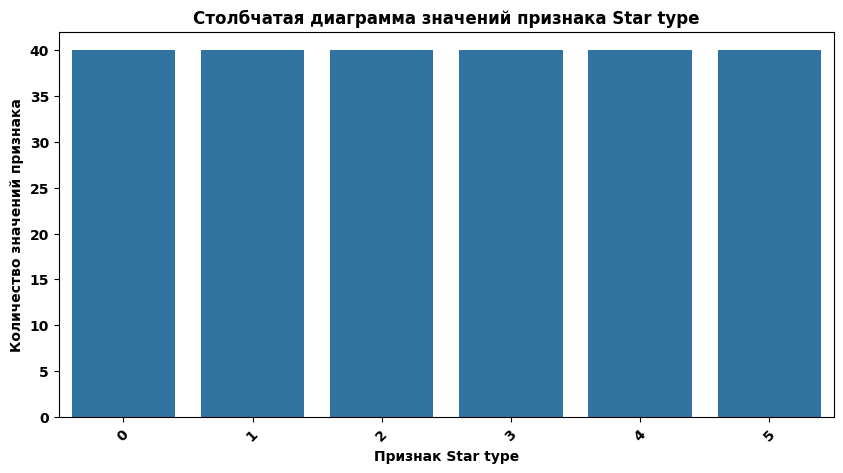

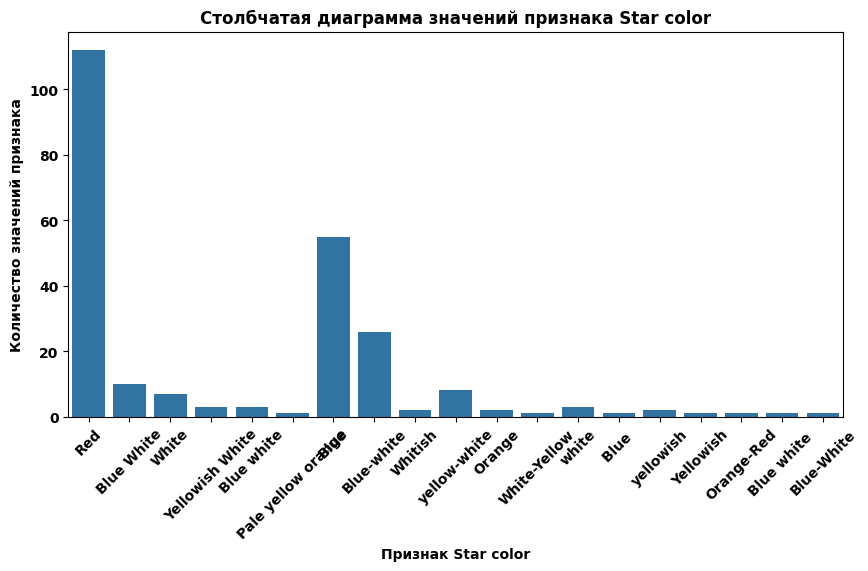

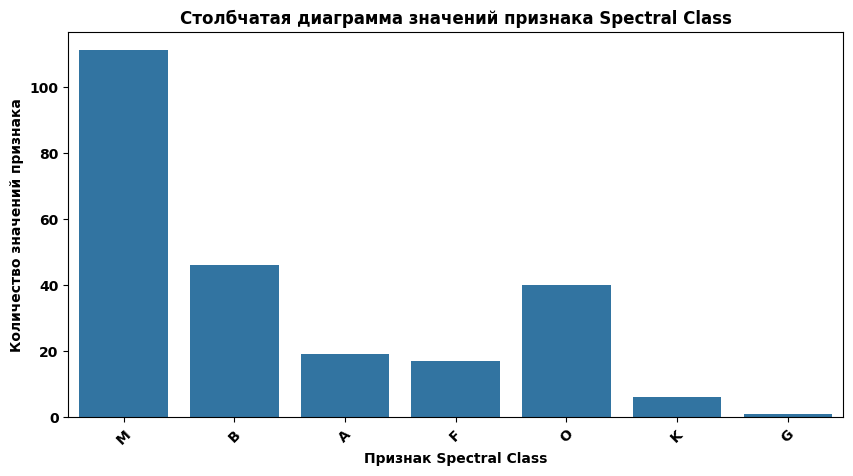

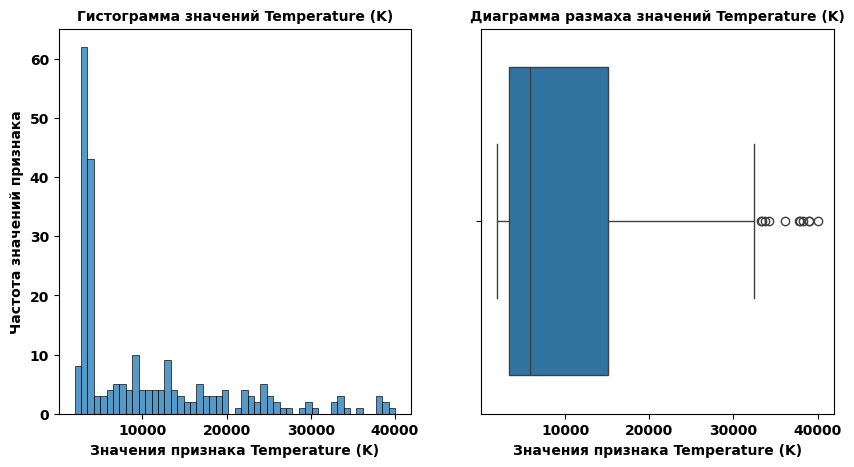

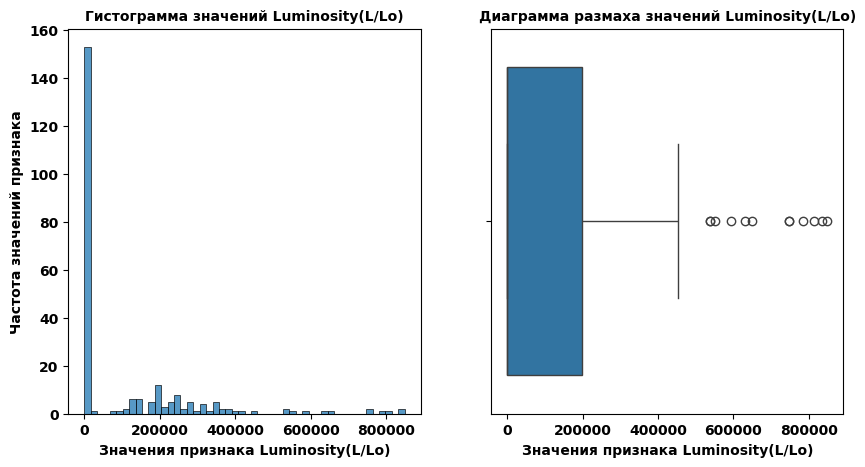

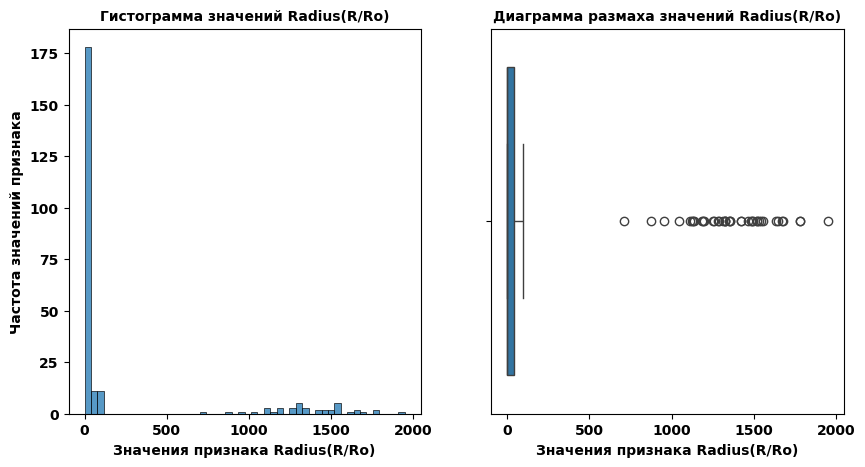

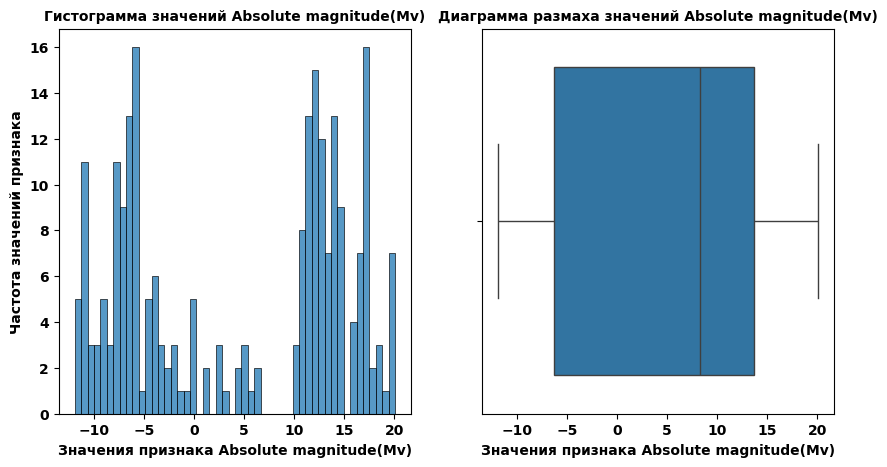

In [7]:
# вывод на экран параметров датасета 'autos'
first_meeting(stars, 'stars')

# вывод на экран графиков дискретных величин по набору 'autos'
for col in ['Star type', 'Star color', 'Spectral Class']:
    num_countplot(stars, col)

# вывод на экран графиков непрерывных количественных величин по набору 'autos'
for col in ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']:
    num_distribution(stars, col, 50)

**Вывод**

1. Произведена загрузка данных в рабочую среду Jupyter Notebook. Инициализирована переменная **stars**;
2. Выведены на экран параметры датасета:
    * В наборе данных **отсутствуют пустые значения** по признакам;
    * Типы данных **соответствуют сущностям значений** по всем рассматриваемым признакам;
    * Названия столбцов **необходимо привести к формату snake_case**;
    * Наблюдаются неявные дубликаты по признаку **Star color**;
    * Наблюдаются выбросы по количественным признакам:
        * **Temperature (K)**;
        * **Luminosity (L/Lo)**;
        * **Radius (R/Ro)**.
    * Самые популярные категории по спектральному классу: **M, B** и **O**;
    * Самые популярные цвета звезд: **Red**, **Pale yellow orange** и **Blue**.

## Предобработка данных <a class = 'anchor' id = 'Предобработка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Приведение названий столбцов к формату snake_case;
2. Обработка неявных дубликатов - значений - по признаку **Star color**;
3. Проверка датасетов на явные дубликаты;
4. Формирование вывода по итогам данного этапа.

In [8]:
# преобразование названий столбцов к формату snake_case
stars.columns = ['_'.join(col.lower().split(' ')) for col in stars.columns]

stars = stars.rename(columns = {
    'temperature_(k)':'temperature',
    'luminosity(l/lo)':'luminosity',
    'radius(r/ro)':'radius',
    'absolute_magnitude(mv)':'absolute_magnitude'
})

In [9]:
# преобразование значений по признаку 'star_color'
stars['star_color'] = (
    stars['star_color']
    .str.lower() # понижение регистра
    .str.strip() # исключение пробелов с конца строк
    .str.replace(' ', '-') # замена знака разделителя
)

# замена значений с перестановкой цвета
stars.loc[stars['star_color'] == 'yellow-white', 'star_color'] = 'white-yellow'

In [10]:
# проверка датасета на явные дубликаты
print('Количество явных дубликатов в наборе данных:', stars.duplicated().sum())
print('Доля дубликатов от общего количества записей в наборе: {:.1%}'.format(stars.duplicated().sum() / stars.shape[0]))

Количество явных дубликатов в наборе данных: 0
Доля дубликатов от общего количества записей в наборе: 0.0%


**Вывод**

1. Названия столбцов приведены к формату snake_case;
2. Обработаны неявные дубликаты - значения - по признаку **Star color**:
    * Понижен регистр значений;
    * Удалены пробелы в конце строк;
    * Заменены пробелы на дефис;
    * Заменены значения с перестановкой цвета.
3. Проверка датасетов на явные дубликаты - **Явные дубликаты отсутствуют**;
4. Набор данных подготовлен к дальнейшему исследовательскому анализу.

## Исследовательский анализ данных <a class = 'anchor' id = 'Исследование'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Вывод на экран основной статистической информации по текущим версиям наборов данных;
2. Исследование соотношения количества значений качественных показателей;
3. Исследование распределения количественных показателей наборов. Построение **гистограмм распределения значений**;
4. Формирование вывода по итогам этапа.

In [12]:
# вывод на экран основных статистик по набору 'data'
print(f'Основная статистическая информация по набору data')
stars.describe(include = 'number')

Основная статистическая информация по набору data


,temperature,luminosity,radius,absolute_magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


**Вывод по промежуточному этапу**

Набор `stars` характеризуется следующими статистическими показателями:

* **temperature - температура звезды в Кельвинах**:
    * Среднее значение - 10 497.5;
    * Минимальное значение - 1 939.0;
    * Максимальное значение - 40 000.0;
    * Стандартное отклонение - 9 552.4.
* **luminosity - относительная светимость**:
    * Среднее значение - 107 188.4;
    * Минимальное значение - 0.0;
    * Максимальное значение - 849 420.0.
    * Стандартное отклонение - 179 432.2.
* **radius - относительный радиус**:
    * Среднее значение - 237.2;
    * Минимальное значение - 0.0084;
    * Максимальное значение - 1 948.5;
    * Стандартное отклонение - 517.2.
* **absolute_magnitude - абсолютная звездная величина**:
    * Среднее значение - 4.4;
    * Минимальное значение - -11.9;
    * Максимальное значение - 20.1;
    * Стандартное отклонение - 10.5.

In [13]:
# инициализация пользовательской функции по формированию вывода информации

def display_info(df: pd.DataFrame, column_name: str, title: str, xlabel: str, kind_of_plot : str):
# построение визуализации по выбранной метрике
    plt.title(title, fontsize = 12)
    if kind_of_plot == 'pie':
        (df[column_name]
         .value_counts()
         .sort_values(ascending=True)
         .plot(kind = kind_of_plot, figsize = (8, 5), autopct='%1.0f%%'))
    else:
        (df[column_name]
         .value_counts()
         .sort_values(ascending=True)
         .plot(kind = kind_of_plot, figsize = (8, 5)))
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)
    plt.xlabel(xlabel)
    plt.show()

# построение сводной таблицы по выбранной метрике
    pivot_data = (df[column_name]
                  .value_counts()
                  .sort_values(ascending=False)
                  .to_frame())
    pivot_data['share_of_stars'] = round(pivot_data['count'] / pivot_data['count'].sum() * 100, 2)
    pivot_data.columns = ['count_of_stars', 'share_of_stars']
    display(pivot_data)

In [14]:
# инициализация пользовательской функции по построению гистограмм по передаваемым метрикам
def histogram_plotting(data: pd.DataFrame, feature : str, bins: int, x_size: int, y_size: int, feature_xlabel : str):
    # вычисление статистических метрик для дальнейшей визуализации
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    upper_bound = q3 + 1.5 * (q3 - q1)
    lower_bound = q1 - 1.5 * (q3 - q1)

    # построение визуализации
    plt.figure(figsize = (x_size, y_size))
    plt.hist(data[feature], color = 'blue', edgecolor = 'white', bins = bins)
    plt.axvline(upper_bound, c = 'red', ls = '-', label = 'верхняя граница допустимых значений')
    plt.axvline(q3, c = 'red', ls = '--', label = '3 квартиль значений')
    plt.axvline(q1, c = 'black', ls = '--', label = '1 квартиль значений')
    plt.axvline(lower_bound, c = 'black', ls = '-', label = 'нижняя граница допустимых значений')
    plt.title(f'Гистограмма распределения значений по метрике: {feature_xlabel}', fontsize = 10)
    plt.xlabel(feature_xlabel)
    plt.ylabel('Количество значений по метрике')
    plt.legend(bbox_to_anchor = (1, 0.6))
    plt.show()

    # вывод статистических метрик на экран
    print('Верхняя допустимая граница значений:', upper_bound)
    print('Нижняя допустимая граница значений:', lower_bound)
    print('Медианное значение:', data[feature].median())
    print('Среднее значение:', round(data[feature].mean(), 2))

    # расчет доли аномальных значений по метрике
    print('Доля значений, выходящих за верхнюю границу: {:.2%}'.format(data[data[feature] > upper_bound].shape[0] / data[feature].shape[0]))
    print('Доля значений, выходящих за нижнюю границу: {:.2%}'.format(data[data[feature] < lower_bound].shape[0] / data[feature].shape[0]))

### Анализ категориальных показателей <a class = 'anchor' id = 'Исследование_качество'></a>

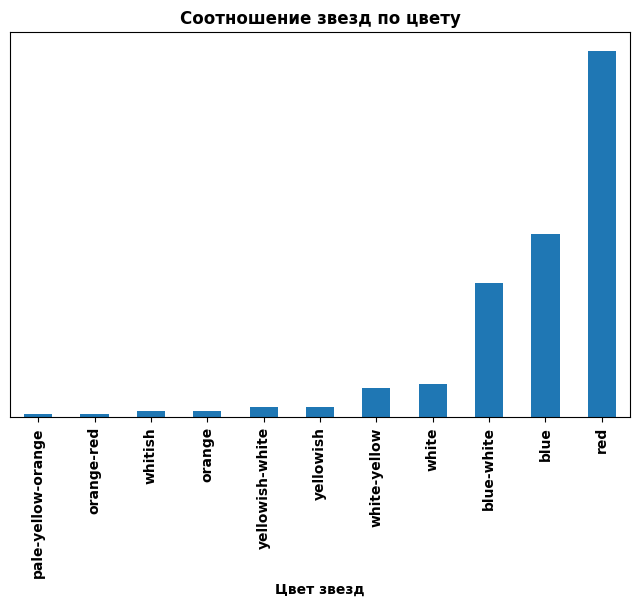

,count_of_stars,share_of_stars
star_color,,
red,112,46.67
blue,56,23.33
blue-white,41,17.08
white,10,4.17
white-yellow,9,3.75
yellowish-white,3,1.25
yellowish,3,1.25
whitish,2,0.83
orange,2,0.83


In [15]:
# построение столбчатой диаграммы по соотношению звезд в зависимости от цвета
display_info(stars, 'star_color', 'Соотношение звезд по цвету', 'Цвет звезд', 'bar')

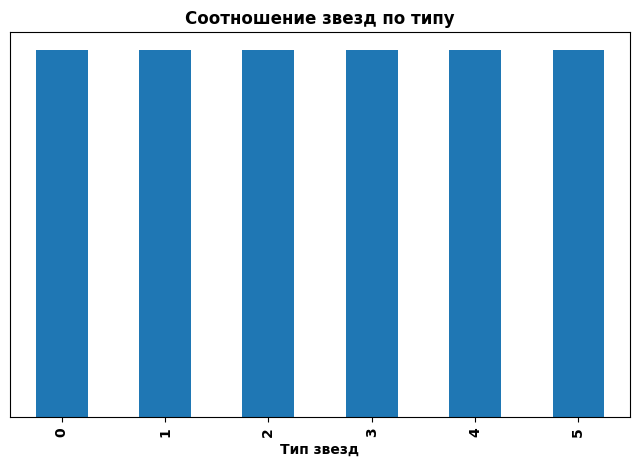

,count_of_stars,share_of_stars
star_type,,
0,40,16.67
1,40,16.67
2,40,16.67
3,40,16.67
4,40,16.67
5,40,16.67


In [16]:
# построение столбчатой диаграммы по соотношению звезд в зависимости от типа
display_info(stars, 'star_type', 'Соотношение звезд по типу', 'Тип звезд', 'bar')

**Вывод по промежуточному этапу**

* Большая часть звезд (87%) представлена тремя основными цветами: **red** (47%), **blue** (23%) и **blue-white** (17%);
* Все звезды распределены в равном отношении друг к другу: **40 представителей в каждом из 6 типов**.

### Анализ количественных показателей <a class = 'anchor' id = 'Исследование_количество'></a>

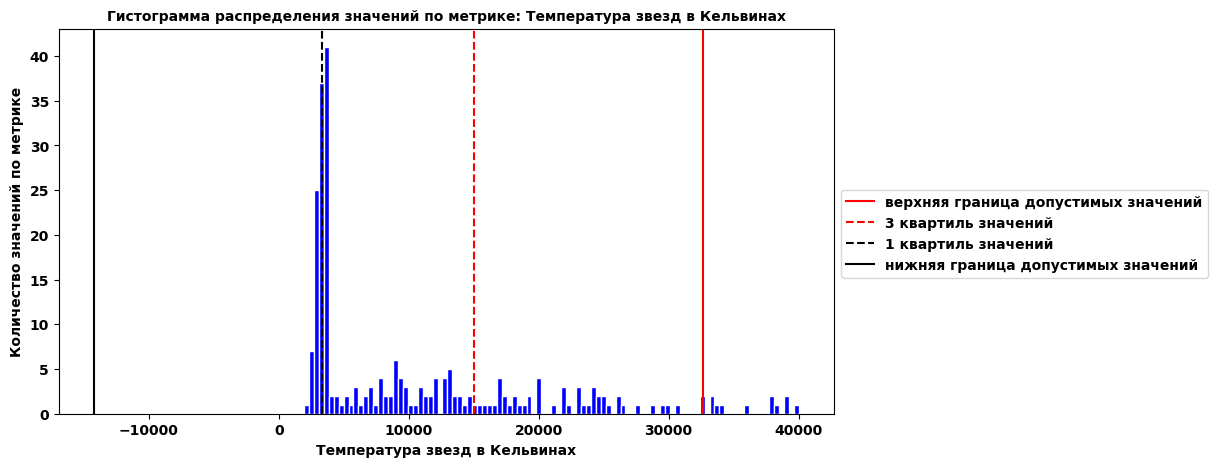

Верхняя допустимая граница значений: 32622.375
Нижняя допустимая граница значений: -14222.625
Медианное значение: 5776.0
Среднее значение: 10497.46
Доля значений, выходящих за верхнюю границу: 4.58%
Доля значений, выходящих за нижнюю границу: 0.00%


In [ ]:
# построение  гистограммы распределения значений по признаку 'temperature'
histogram_plotting(stars, 'temperature', 100, 10, 5, 'Температура поверхности звезд в Кельвинах')

**Вывод по промежуточному этапу**

В наборе данных по рассматриваемому признаку - **temperature** - имеются аномально большие значения: **4.6%**
Вероятно, что подобные показатели принадлежат звездам главной последовательности, сверхгигантам и гипергигантам - в таком случае наблюдаемые значения не подлежат исключению.

In [28]:
# сводная таблица со средними температурами звезд в зависимости от типа
temp_pivot = stars.pivot_table(index = 'star_type', values = 'temperature', aggfunc = ['mean', 'median'])
temp_pivot.columns = ['temp_mean', 'temp_median']

temp_pivot.sort_values('temp_median', ascending = False)

,temp_mean,temp_median
star_type,,
2,13931.450,13380.0
4,15347.850,12821.0
3,16018.000,12560.5
5,11405.700,3766.0
1,3283.825,3314.0
0,2997.950,2935.0


In [ ]:
# вывод уникальных типов звезд для аномально больших значений по признаку 'temperature'
print('Типы звезд с аномально большими значениями температуры:', 
      stars[stars['temperature'] > stars['temperature'].quantile(0.75) + 1.5 * (stars['temperature'].quantile(0.75) - stars['temperature'].quantile(0.25))]['star_type'].unique())

Типы звезд с аномально большими значениями температуры: [3 4 5]


**Вывод по промежуточному этапу**

По итогам анализа определено, что аномально **высокие температуры характерны для звезд типа 2, 3 и 4** (Белый карлик, Звезды главной последовательности и Сверхгиганты, соответственно).

**Наличие среди этих объектов звезды типа 5 - Сверхгигант - является уникальной ситуацией, но не подлежащей исключению из набора**.

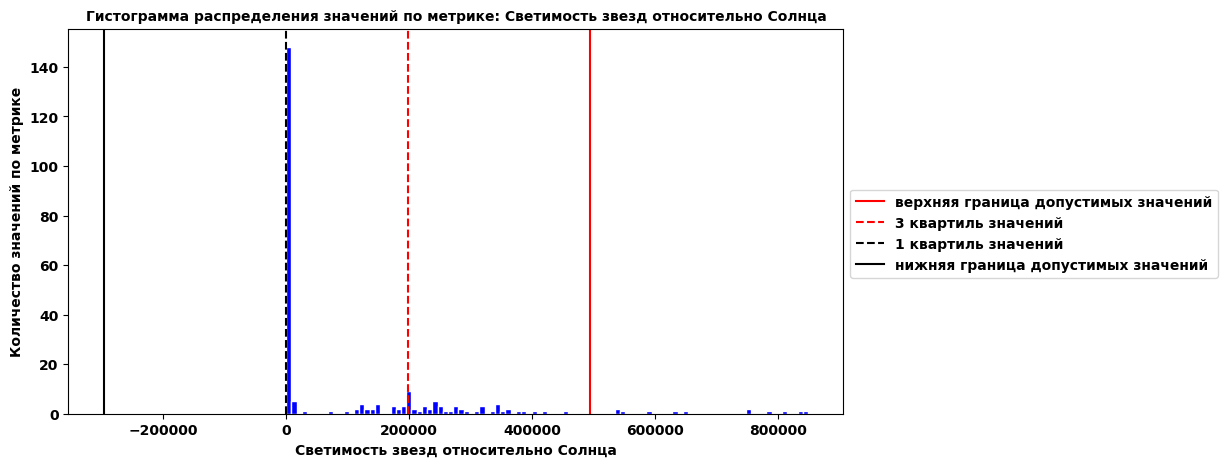

Верхняя допустимая граница значений: 495124.998702875
Нижняя допустимая граница значений: -297074.997838125
Медианное значение: 0.07050000000000001
Среднее значение: 107188.36
Доля значений, выходящих за верхнюю границу: 5.00%
Доля значений, выходящих за нижнюю границу: 0.00%


In [18]:
# построение  гистограммы распределения значений по признаку 'luminosity'
histogram_plotting(stars, 'luminosity', 100, 10, 5, 'Светимость звезд относительно Солнца')

**Вывод по промежуточному этапу**

Наблюдаются две обособленные от общей массы группы звезд, выходящие за верхнюю границу допустимых значений - 500 000
Необходимо изучить данные объекты для лучшего понимания природы такой картины.

In [30]:
# получение среза данных по объектам с аномально большой светимостью
max_luminosity = stars[stars['luminosity'] > stars['luminosity'].quantile(0.75) + 1.5 * (stars['luminosity'].quantile(0.75) - stars['luminosity'].quantile(0.25))]

# построение сводной таблицы по объектам с аномально большой светимостью
max_luminosity.groupby('star_type').agg({
    'temperature' : 'mean',
    'luminosity' : 'count'
})

,temperature,luminosity
star_type,,
4,21200.0,5
5,18548.0,7


**Вывод по промежуточному этапу**

Объекты с аномально большой светимостью относятся к типу 4 и 5 - **Сверхгиганты и Гипергиганты, соответственно**.

**Данные объекты не подлежат исключению из набора**.

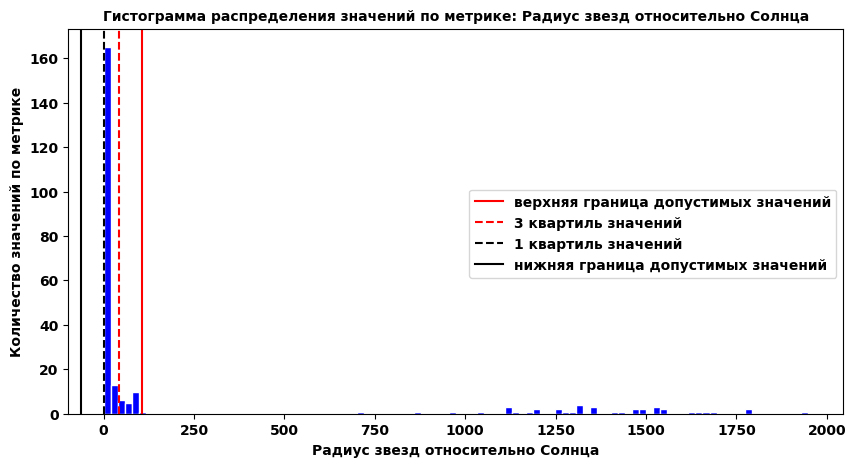

Верхняя допустимая граница значений: 106.720875
Нижняя допустимая граница значений: -63.868125
Медианное значение: 0.7625
Среднее значение: 237.16
Доля значений, выходящих за верхнюю границу: 16.67%
Доля значений, выходящих за нижнюю границу: 0.00%


In [19]:
# построение  гистограммы распределения значений по признаку 'radius'
histogram_plotting(stars, 'radius', 100, 10, 5, 'Радиус звезд относительно Солнца')

In [31]:
# получение среза данных по объектам с аномально большими радиусами относительно Солнца
max_radius = stars[stars['radius'] > stars['radius'].quantile(0.75) + 1.5 * (stars['radius'].quantile(0.75) - stars['radius'].quantile(0.25))]

# построение сводной таблицы по объектам с аномально большой светимостью
max_radius.groupby('star_type').agg({
    'temperature' : 'mean',
    'radius' : 'count'
})

,temperature,radius
star_type,,
5,11405.7,40


**Вывод по промежуточному этапу**

Объекты с аномально большими радиусами относительно Солнца относятся к типу 5 - **Гипергиганты**

**Данные объекты не подлежат исключению из набора**.

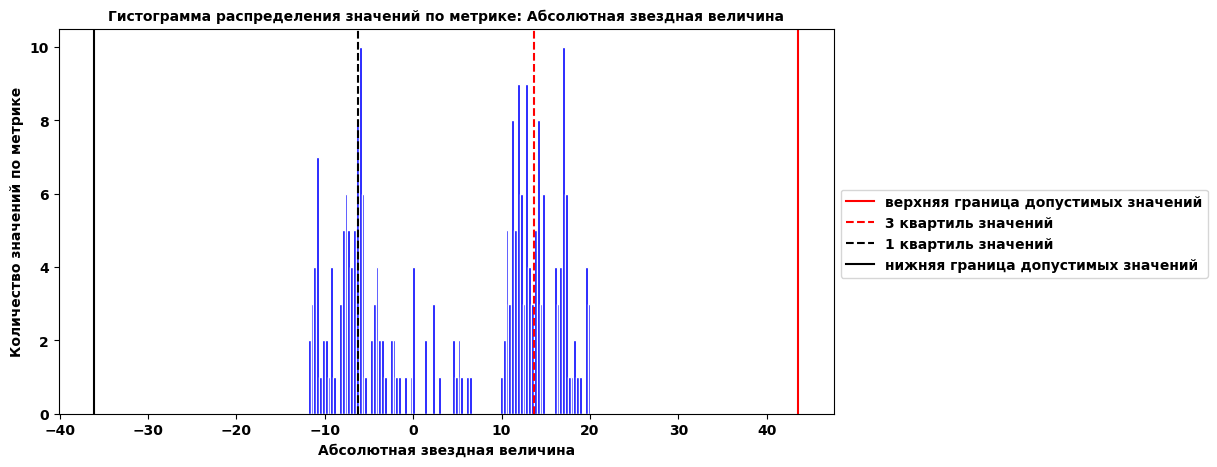

Верхняя допустимая граница значений: 43.5925
Нижняя допустимая граница значений: -36.1275
Медианное значение: 8.312999999999999
Среднее значение: 4.38
Доля значений, выходящих за верхнюю границу: 0.00%
Доля значений, выходящих за нижнюю границу: 0.00%


In [20]:
# построение  гистограммы распределения значений по признаку 'temperature'
histogram_plotting(stars, 'absolute_magnitude', 100, 10, 5, 'Абсолютная звездная величина')

**Вывод по промежуточному этапу**

Наблюдается **бимодальное распределение значений**, находящееся в пределах допустимых границ.

**Очистки набора данных от аномальных значений по данному признаку не требуется**

**Вывод**

**Вывод по промежуточному этапу**

1. Набор `stars` характеризуется следующими статистическими показателями:
    * **temperature - температура звезды в Кельвинах**:
        * Среднее значение - 10 497.5;
        * Минимальное значение - 1 939.0;
        * Максимальное значение - 40 000.0;
        * Стандартное отклонение - 9 552.4.
    * **luminosity - относительная светимость**:
        * Среднее значение - 107 188.4;
        * Минимальное значение - 0.0;
        * Максимальное значение - 849 420.0.
        * Стандартное отклонение - 179 432.2.
    * **radius - относительный радиус**:
        * Среднее значение - 237.2;
        * Минимальное значение - 0.0084;
        * Максимальное значение - 1 948.5;
        * Стандартное отклонение - 517.2.
    * **absolute_magnitude - абсолютная звездная величина**:
        * Среднее значение - 4.4;
        * Минимальное значение - -11.9;
        * Максимальное значение - 20.1;
        * Стандартное отклонение - 10.5.
2. Произведен анализ категориальных данных:
    * Большая часть звезд (87%) представлена тремя основными цветами: **red** (47%), **blue** (23%) и **blue-white** (17%);
    * Все звезды распределены в равном отношении друг к другу: **40 представителей в каждом из 6 типов**.
3. Проведен анализ количественных признаков:
    * Анализ признака **temperature**:
        * **Высокие температуры характерны для звезд типа 2, 3 и 4** (Белый карлик, Звезды главной последовательности и Сверхгиганты, соответственно);
        * **Наличие среди этих объектов звезды типа 5 - Сверхгигант - является уникальной ситуацией, но не подлежащей исключению из набора**.
    * Анализ признака **luminosity**:
        * Объекты с аномально большой светимостью относятся к типу 4 и 5 - **Сверхгиганты и Гипергиганты, соответственно**.
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
    * Анализ признака **radius**:
        * Объекты с аномально большими радиусами относительно Солнца относятся к типу 5 - **Гипергиганты**;
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
    * Анализ признака **absolute_magnitude**:
        * Наблюдается **бимодальное распределение значений**, находящееся в пределах допустимых границ.
        * **Очистки набора данных от аномальных значений по данному признаку не требуется**.
4. Набор данных подготовлен к дальнейшему использованию в проектировании нейросети.

## Корреляционный анализ данных <a class = 'anchor' id = 'Корреляция'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Построение матрицы корреляции - поиск признаков высокой взаимосвязи показателей объектов;
2. Проведение отбора признаков для последующего построения моделей машинного обучения;
3. Формирование вывода по итогам данного этапа.